In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
import os
import glob
#import shutil

import xarray as xr
import numpy as np
#from pyhomogenize import open_xrdataset
#import seaborn as sns
#
import matplotlib as mpl
import matplotlib.pyplot as plt
import cftime

In [45]:
from plotting_tools_africa import savefig, directory_available, plot_2diff,plot_absolut
from plotting_tools_exposure import plot_2diff_pop, plot_absolute_pop, plot_2_diff_exposure
from format_data_tools import decode_time_pop, save_file_to_netcdf
from colors_indices import colorsteps_diff, colorsteps_absolute

In [46]:
# Directories need to be defined
pop_dir = '/work/ch0636/g300047/cicles/population/'
database='/work/ch0636/g300047/cicles/'
data_dir = database + '/climate_fact_data/results_bulletin/'
plot_dir = database + 'horizontal-plots-exposure-bulletin/'

In [47]:
directory_available(plot_dir)

In [48]:
def sel_time_mean(ds, start, end):
    return ds.sel(time=slice(start, end)).mean(dim="time")

### Next Box: 
#### Only execute once, or delete output file before

In [ ]:
#
#Calculate mean population
# 1991-2024 and  2031-2060
pop_1991_2024_ssp1 = sel_time_mean(pop_ssp1, "1991-01-01", "2024-12-31")
pop_2031_2060_ssp1 = sel_time_mean(pop_ssp1, "2031-01-01", "2060-12-31")
diff_pop_ssp1 = pop_2031_2060_ssp1 - pop_1991_2024_ssp1
#Calculate mean population
# 1991-2024 and  2031-2060
pop_1991_2024_ssp3 = sel_time_mean(pop_ssp3, "1991-01-01", "2024-12-31")
pop_2031_2060_ssp3 = sel_time_mean(pop_ssp3, "2031-01-01", "2060-12-31")
diff_pop_ssp3 = pop_2031_2060_ssp3 - pop_1991_2024_ssp3

save_file_to_netcdf(pop_1991_2024_ssp1, pop_dir, '/pop_1991_2024_ssp1.nc')
save_file_to_netcdf(pop_2031_2060_ssp1, pop_dir, '/pop_2031_2060_ssp1.nc')

save_file_to_netcdf(pop_1991_2024_ssp3, pop_dir, '/pop_1991_2024_ssp3.nc')
save_file_to_netcdf(pop_2031_2060_ssp3, pop_dir, '/pop_2031_2060_ssp3.nc')

save_file_to_netcdf(diff_pop_ssp1, pop_dir, '/pop_diff_2031_2060_ssp1.nc')
save_file_to_netcdf(diff_pop_ssp3, pop_dir, '/pop_diff_2031_2060_ssp3.nc')


AttributeError: 'Dataset' object has no attribute 'describe'

In [49]:
# get list of population diff and absolute files
pop_ssp1 = [
    pop_dir+ '/pop_1991_2024_ssp1.nc',
    pop_dir+ '/pop_2031_2060_ssp1.nc']
pop_ssp3 = [
    pop_dir+ '/pop_1991_2024_ssp3.nc',
    pop_dir+ '/pop_2031_2060_ssp3.nc']
pop_diff_ssp1 = [
    pop_dir+ '/pop_diff_2031_2060_ssp1.nc']
pop_diff_ssp3 = [
    pop_dir+ '/pop_diff_2031_2060_ssp3.nc']
pop_diff_ssp1


['/work/ch0636/g300047/cicles/population//pop_diff_2031_2060_ssp1.nc']

In [50]:
def diff_exposure(pop_ref, index_ref, diff_pop, diff_index, var):
    """
    Calculate the change of exposure of a person 
    to changing climate variable and change in  population
    literature: Liu et al. , 2016, Weber et al. 2020,
    """
    # Calculate the exposure
    p_ref = xr.open_dataset(pop_ref,decode_timedelta=False)
    diff_p = xr.open_dataset(diff_pop,decode_timedelta=False)
    i_ref = xr.open_dataset(index_ref,decode_timedelta=False)
    diff_i = xr.open_dataset(diff_index,decode_timedelta=False)

    exp = xr.Dataset()
    exp['exposure'] = p_ref['number_of_people'] * diff_i[var] + i_ref[var] * diff_p['number_of_people'] + diff_i[var] * diff_p['number_of_people']

    return exp

## climate data in this case it is SU40

In [52]:
# Detemine the variable 
# Time resolution you like
#var='SU30'
#var='SU35'
var='SU40'
#var='TG'
#var='HSn'
#var='HSx'
#var='HSf'
#var='HWf'
#var='HWn'
#var='HWx'
#var='WSDI'
#var='DTR'

robust='_ensemble-robustness.nc'
list_rcp26 = "rcp26"
list_rcp85 = "rcp85"
title_part="Ensemble Mean of the change compared to 1991-2025: \n "

In [53]:
# Get the list of files for difference plots
timefreq='year_2'
# Chose if you like median or mean 
what='_time-mean_ensemble-diff-mean.nc'
sims_rcp26_diff = glob.glob(data_dir+'/'+var+'/'+var+'*'+timefreq+'*'+list_rcp26+'*'+what)
sims_rcp85_diff = glob.glob(data_dir+'/'+var+'/'+var+'*'+timefreq+'*'+list_rcp85+'*'+what)
robust_rcp26 = glob.glob(data_dir+'/'+var+'/'+var+'*'+timefreq+'*'+list_rcp26+'*'+robust)
robust_rcp85 = glob.glob(data_dir+'/'+var+'/'+var+'*'+timefreq+'*'+list_rcp85+'*'+robust)
# Sort the files to ensure correct order
sims_rcp26_diff.sort()
sims_rcp85_diff.sort()
robust_rcp26.sort()
robust_rcp85.sort()

In [54]:
# Get the list of files for absolute plots
timefreq='year'
what='_time-mean_ensemble-mean.nc'
sims_rcp26 = glob.glob(data_dir+'/'+var+'/'+var+'*'+timefreq+'*'+list_rcp26+'*'+what)
sims_rcp85 = glob.glob(data_dir+'/'+var+'/'+var+'*'+timefreq+'*'+list_rcp85+'*'+what)
# Sort the files to ensure correct order
sims_rcp26.sort()
sims_rcp85.sort()

### For the plots you have to make some decisions in the next box:
* Do you like to plot West Africa (True) or Africa (False)
* user_dpi is the resolution of the saved figure, for printing 1200 is recommended, otherwise use 300, which is faster

Selected colors, levels for plotting  SU40
['/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_1991_2024_rcp26_time-mean_ensemble-mean.nc', '/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp26_time-mean_ensemble-mean.nc']
['/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_1991_2024_rcp85_time-mean_ensemble-mean.nc', '/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp85_time-mean_ensemble-mean.nc']
sims_rcp26 ['/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_1991_2024_rcp26_time-mean_ensemble-mean.nc', '/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp26_time-mean_ensemble-mean.nc']
/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_1991_2024_rcp26_time-mean_ensemble-mean.nc
nothing to do, unit exists
/work/ch0636/g300047/cicles//climate_

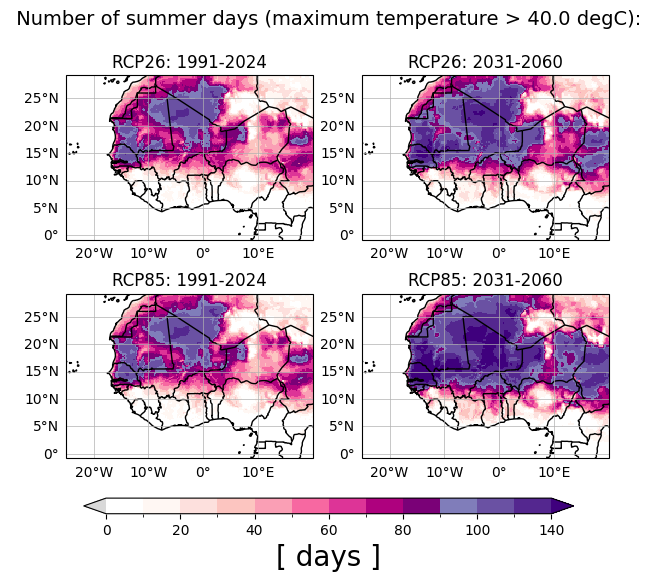

In [55]:
print('Selected colors, levels for plotting ', var)

color_steps, level_steps = colorsteps_absolute(var)

plot_absolut(
    sims_rcp26,
    sims_rcp85,
    level_steps, 
    color_steps,    
    plot_dir,
    title="",
    var=var,
    westafrica=True,
    user_dpi=300,
    rows=2, 
    columns=2,
    )

['/work/ch0636/g300047/cicles/population//pop_1991_2024_ssp1.nc', '/work/ch0636/g300047/cicles/population//pop_2031_2060_ssp1.nc']
['/work/ch0636/g300047/cicles/population//pop_1991_2024_ssp3.nc', '/work/ch0636/g300047/cicles/population//pop_2031_2060_ssp3.nc']
/work/ch0636/g300047/cicles/population//pop_1991_2024_ssp1.nc
/work/ch0636/g300047/cicles/population//pop_2031_2060_ssp1.nc
plot ist saved in :  /work/ch0636/g300047/cicles/horizontal-plots-exposure-bulletin//number_of_people_absolut_West_Africa_300.png


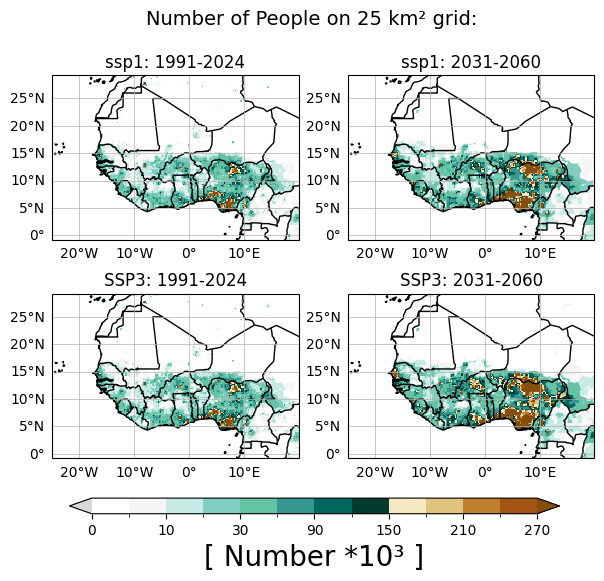

In [56]:
plot_absolute_pop(
    pop_ssp1,
    pop_ssp3,    
    plot_dir,
    title="on 25 km² grid",
    var='number_of_people',
    westafrica=True,
    user_dpi=300,
    rows=2, 
    columns=2,
    )

In [57]:
# look at input files

df = xr.open_dataset(sims_rcp26_diff[0], decode_timedelta=False)
df= xr.open_dataset(pop_diff_ssp3[0], decode_timedelta=False)
df['number_of_people'].to_dataframe().describe()
#df['SU40'].to_dataframe().describe()

,lon,lat,number_of_people
count,155976.000000,155976.000000,1.559760e+05
mean,17.820000,-1.760000,9.007015e+03
std,24.641307,25.530432,4.781305e+04
min,-24.750000,-45.870000,-1.109083e+06
25%,-3.465000,-23.870000,0.000000e+00
50%,17.820000,-1.760000,0.000000e+00
75%,39.105000,20.350000,2.530704e+03
max,60.390000,42.350000,2.753758e+06


file:  /work/ch0636/g300047/cicles/population//pop_diff_2031_2060_ssp1.nc
plot ist saved in :  /work/ch0636/g300047/cicles/horizontal-plots-exposure-bulletin//number_of_people_diff_West_Africa_300.png


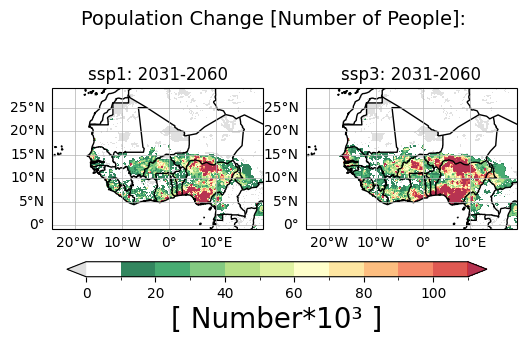

In [58]:
#Plot 2 diff for population
plot_2diff_pop(
     pop_diff_ssp1,
     pop_diff_ssp3,
     plot_dir,
     title='Population Change',
     var='number_of_people',
     #westafrica=False, 
     westafrica=True,
     user_dpi=300,
    )


Selected colors, levels for plotting  SU40
/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp26_time-mean_ensemble-diff-mean.nc
nothing to do, unit exists
rcp85
/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp85_time-mean_ensemble-diff-mean.nc


/home/g/g300047/SCRIPTS/github/heat-indicators-africa/Notebooks/plotting_tools_africa.py:158: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datar = xr.open_dataset(robust_rcp26)
/home/g/g300047/SCRIPTS/github/heat-indicators-africa/Notebooks/plotting_tools_africa.py:53: SerializationWarning: Can't decode floating point timedelta to 's' without precision loss, decoding to 'ns' instead. To silence this warning use time_unit='ns' in call to decoding function.
  data_variable= data.where(land_mask.values == 1)
/home/g/g300047/SCRIPTS/github/heat-indicators-africa/Notebooks/plotting_tools_africa.py:195: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datar = xr.open_dataset(robust_rcp85)
/h

plot ist saved in :  /work/ch0636/g300047/cicles/horizontal-plots-exposure-bulletin//SU40_diff-robust_West_Africa_300.png


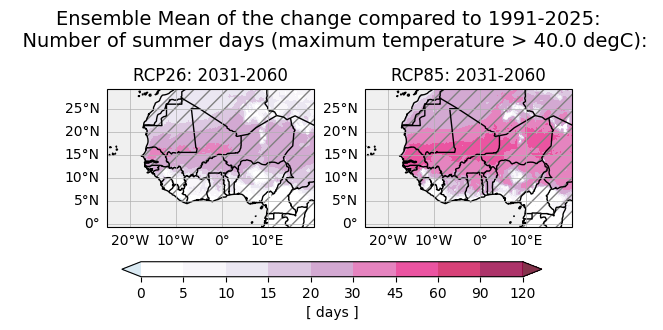

In [71]:
# get colors and levels for plotting
print('Selected colors, levels for plotting ', var)

color_steps_diff, level_steps_diff = colorsteps_diff(var)

plot_2diff(
     sims_rcp26_diff,
     sims_rcp85_diff,
     robust_rcp26,
     robust_rcp85,
     level_steps_diff,
     color_steps_diff,
     what,
     robust,
     plot_dir,
     title=title_part,
     var=var,
     robustness=True,
     #westafrica=False, 
     westafrica=True,
     user_dpi=300,
    )

In [ ]:
# Here for Bulletin, which has only one future time slot:

exposure_change_ssp1 = diff_exposure(pop_ssp1[0], sims_rcp26[0], pop_diff_ssp1[0], sims_rcp26_diff[0], var)
exposure_change_ssp3 = diff_exposure(pop_ssp3[0], sims_rcp85[0], pop_diff_ssp3[0], sims_rcp85_diff[0], var)
# Save exposure to netcdf
#print(exposure_change_ssp1)
#print(exposure_change_ssp3)

save_file_to_netcdf(exposure_change_ssp1, pop_dir, '/exposure_change_ssp1_2031_2060.nc')
save_file_to_netcdf(exposure_change_ssp3, pop_dir, '/exposure_change_ssp3_2031_2060.nc')
# put in List
exposure_ssp1 = [pop_dir+ '/exposure_change_ssp1_2031_2060.nc',]
exposure_ssp3 = [pop_dir+ '/exposure_change_ssp3_2031_2060.nc',]

Exposure of population to :  SU40


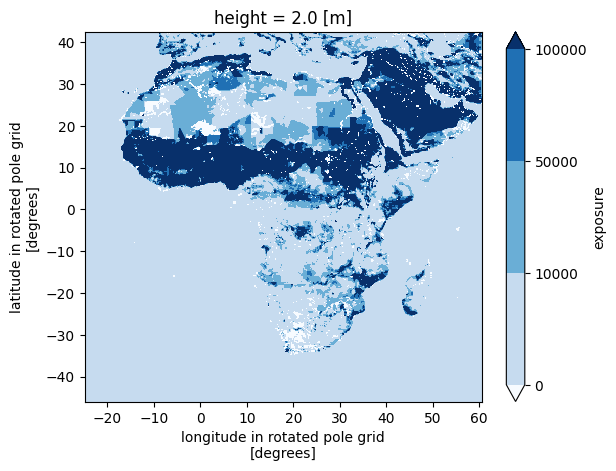

In [39]:
print('Exposure of population to : ',var)
ssp1 = xr.open_dataset(exposure_ssp1[0],decode_timedelta=False)
#exposure_ssp3 = xr.open_dataset(exposure_ssp3[0],decode_timedelta=False)
ssp1['exposure'].plot(levels=[0,10000,50000,100000], cmap='Blues', add_colorbar=True)

In [40]:
print('Exposure of population to : ',var)
print('for the following files:')
print(exposure_ssp1[0])
print(exposure_ssp3[0])
print(robust_rcp26[0])
print(robust_rcp85[0])

Exposure of population to :  SU40
for the following files:
/work/ch0636/g300047/cicles/population//exposure_change_ssp1_2031_2060.nc
/work/ch0636/g300047/cicles/population//exposure_change_ssp3_2031_2060.nc
/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp26_ensemble-robustness.nc
/work/ch0636/g300047/cicles//climate_fact_data/results_bulletin//SU40/SU40_year_2031_2060_rcp85_ensemble-robustness.nc


In [32]:
# get colors and levels for plotting
#KB Hier weitermachen

print('Selected colors, levels for plotting ', var)

color_steps_diff, level_steps_diff = colorsteps_diff(var)

plot_2_diff_exposure(
     exposure_ssp1[0],
     exposure_ssp3[0],
     robust_rcp26[0],
     robust_rcp85[0],
     plot_dir,
     title='Change of Exposure of People to SU40', # unit person-events
     var='exposure',
     varr='SU40',
     robustness=True,
     #westafrica=False, 
     westafrica=True,
     user_dpi=300,
    )

Selected colors, levels for plotting  SU40


NameError: name 'exposure_ssp1' is not defined